In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

### Read the CSV and Perform Basic Data Cleaning

In [2]:
df = pd.read_csv("exoplanet_data.csv")
# Drop the null columns where all values are null
df = df.dropna(axis='columns', how='all')
# Drop the null rows
df = df.dropna()
df.head()

,koi_disposition,koi_fpflag_nt,koi_fpflag_ss,koi_fpflag_co,koi_fpflag_ec,koi_period,koi_period_err1,koi_period_err2,koi_time0bk,koi_time0bk_err1,...,koi_steff_err2,koi_slogg,koi_slogg_err1,koi_slogg_err2,koi_srad,koi_srad_err1,koi_srad_err2,ra,dec,koi_kepmag
0,CONFIRMED,0,0,0,0,54.418383,2.479000e-04,-2.479000e-04,162.513840,0.003520,...,-81,4.467,0.064,-0.096,0.927,0.105,-0.061,291.93423,48.141651,15.347
1,FALSE POSITIVE,0,1,0,0,19.899140,1.490000e-05,-1.490000e-05,175.850252,0.000581,...,-176,4.544,0.044,-0.176,0.868,0.233,-0.078,297.00482,48.134129,15.436
2,FALSE POSITIVE,0,1,0,0,1.736952,2.630000e-07,-2.630000e-07,170.307565,0.000115,...,-174,4.564,0.053,-0.168,0.791,0.201,-0.067,285.53461,48.285210,15.597
3,CONFIRMED,0,0,0,0,2.525592,3.760000e-06,-3.760000e-06,171.595550,0.001130,...,-211,4.438,0.070,-0.210,1.046,0.334,-0.133,288.75488,48.226200,15.509
4,CONFIRMED,0,0,0,0,4.134435,1.050000e-05,-1.050000e-05,172.979370,0.001900,...,-232,4.486,0.054,-0.229,0.972,0.315,-0.105,296.28613,48.224670,15.714


### Select features (X) and y

In [3]:
X = df.drop("koi_disposition",axis=1)
y = df['koi_disposition']

### Create a Train Test Split

In [4]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    random_state=1, 
                                                    stratify=y)

### Pre-Processing

Scale the data using the MinMaxScaler and perform some feature selection

In [5]:
# Scale your data
from sklearn.preprocessing import MinMaxScaler
X_scaler = MinMaxScaler().fit(X_train)
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

/Users/morganivey/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


### Train the Model

In [6]:
# Create a logistic regression model
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(multi_class='auto', solver='lbfgs', max_iter=500)
model

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=500, multi_class='auto',
          n_jobs=None, penalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)

In [7]:
model.fit(X_train_scaled,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=500, multi_class='auto',
          n_jobs=None, penalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)

In [8]:
# Score the original model
original_model_train_score = model.score(X_train_scaled, y_train)
original_model_test_score = model.score(X_test_scaled, y_test)

#Print the original model training and testing scores
print(f"Training Data Score: {original_model_train_score}")
print(f"Testing Data Score: {original_model_test_score}")

Training Data Score: 0.8502765592218196
Testing Data Score: 0.8506864988558352


In [9]:
# Create predicition and classification report for original model
from sklearn.metrics import classification_report
prediction = model.predict(X_test_scaled)
original_classification_report = classification_report(y_test,prediction,
                            target_names=['CANDIDATE','CONFIRMED','FALSE POSITIVE'])
print(original_classification_report)

                precision    recall  f1-score   support

     CANDIDATE       0.76      0.61      0.68       422
     CONFIRMED       0.69      0.79      0.74       450
FALSE POSITIVE       0.98      1.00      0.99       876

     micro avg       0.85      0.85      0.85      1748
     macro avg       0.81      0.80      0.80      1748
  weighted avg       0.85      0.85      0.85      1748



In [10]:
from sklearn.feature_selection import RFE
num_features = len(X_train.columns) #40 total
num_top_features_list = [5,10,15,20,25,30]
top_train_score = 0
top_test_score = 0
for num_top_features in num_top_features_list:

    rfe = RFE(estimator=model, n_features_to_select=num_top_features,step=1)
    rfe.fit(X_train_scaled,y_train)


    ranks=rfe.ranking_
    n_features=num_top_features
    feature_indexes=[]
    for i in range(0,len(ranks)):
        if ranks[i]==1:
            feature_indexes+=[i]
    X_train_new = rfe.transform(X_train_scaled)
    X_test_new = rfe.transform(X_test_scaled)

    model_rfe = LogisticRegression(multi_class='auto', solver='lbfgs', max_iter=500)

    model_rfe.fit(X_train_new,y_train)
    print(f'Number of Important Features : {num_top_features} ')
    train_score = model_rfe.score(X_train_new, y_train)
    test_score = model_rfe.score(X_test_new, y_test)
    print(f"Training Data Score: {train_score}")
    print(f"Testing Data Score: {test_score}")
    if train_score > top_train_score:
        top_train_score = train_score
        top_num_features_train = num_top_features
    if test_score > top_test_score:
        top_test_score = test_score
        top_num_features_test = num_top_features
    prediction_rfe = model_rfe.predict(X_test_new)
    print(classification_report(y_test,prediction_rfe,
                                target_names=['CANDIDATE','CONFIRMED','FALSE POSITIVE']))
    print('==============================================')
    
print(f'The highest train score is {top_train_score} with {top_num_features_train} features')
print(f'The highest test score is {top_test_score} with {top_num_features_test} features')

#Best Model:
rfe = RFE(estimator=model, n_features_to_select=top_num_features_test,step=1)
rfe.fit(X_train_scaled,y_train)


ranks=rfe.ranking_
n_features=top_num_features_test
feature_indexes=[]
for i in range(0,len(ranks)):
    if ranks[i]==1:
        feature_indexes+=[i]
X_train_new = rfe.transform(X_train_scaled)
X_test_new = rfe.transform(X_test_scaled)


model_rfe = LogisticRegression(multi_class='auto', solver='lbfgs', max_iter=500)
model_rfe.fit(X_train_new,y_train)
train_score = model_rfe.score(X_train_new, y_train)
test_score = model_rfe.score(X_test_new, y_test)
print('==============================================')
print(f'The best model to be used has {top_num_features_test} features:')
print(f"Training Data Score: {train_score}")
print(f"Testing Data Score: {test_score}")
prediction_rfe = model_rfe.predict(X_test_new)
print(classification_report(y_test,prediction_rfe,
                            target_names=['CANDIDATE','CONFIRMED','FALSE POSITIVE']))
print('==============================================')

Number of Important Features : 5 
Training Data Score: 0.819568949074957
Testing Data Score: 0.8289473684210527
                precision    recall  f1-score   support

     CANDIDATE       0.87      0.42      0.57       422
     CONFIRMED       0.62      0.92      0.74       450
FALSE POSITIVE       0.98      0.98      0.98       876

     micro avg       0.83      0.83      0.83      1748
     macro avg       0.82      0.77      0.76      1748
  weighted avg       0.86      0.83      0.82      1748

Number of Important Features : 10 
Training Data Score: 0.8411214953271028
Testing Data Score: 0.8312356979405034
                precision    recall  f1-score   support

     CANDIDATE       0.71      0.57      0.63       422
     CONFIRMED       0.66      0.76      0.70       450
FALSE POSITIVE       0.98      1.00      0.99       876

     micro avg       0.83      0.83      0.83      1748
     macro avg       0.78      0.77      0.77      1748
  weighted avg       0.83      0.83      

### Hyperparameter Tuning using GridSearchCV

In [11]:
# Create the GridSearchCV model
from sklearn.model_selection import GridSearchCV
params_grid = {'C': [1, 5, 10],
              'max_iter': [500, 1000, 5000]
              }
grid = GridSearchCV(model, params_grid, verbose=2)

In [12]:
grid.fit(X_train_new,y_train)

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV] C=1, max_iter=500 ...............................................


/Users/morganivey/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ................................ C=1, max_iter=500, total=   0.3s
[CV] C=1, max_iter=500 ...............................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s


[CV] ................................ C=1, max_iter=500, total=   0.3s
[CV] C=1, max_iter=500 ...............................................
[CV] ................................ C=1, max_iter=500, total=   0.1s
[CV] C=1, max_iter=1000 ..............................................
[CV] ............................... C=1, max_iter=1000, total=   0.2s
[CV] C=1, max_iter=1000 ..............................................
[CV] ............................... C=1, max_iter=1000, total=   0.3s
[CV] C=1, max_iter=1000 ..............................................
[CV] ............................... C=1, max_iter=1000, total=   0.2s
[CV] C=1, max_iter=5000 ..............................................
[CV] ............................... C=1, max_iter=5000, total=   0.2s
[CV] C=1, max_iter=5000 ..............................................
[CV] ............................... C=1, max_iter=5000, total=   0.2s
[CV] C=1, max_iter=5000 ..............................................
[CV] .

/Users/morganivey/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


[CV] ............................... C=10, max_iter=500, total=   0.5s
[CV] C=10, max_iter=500 ..............................................


/Users/morganivey/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


[CV] ............................... C=10, max_iter=500, total=   0.9s
[CV] C=10, max_iter=500 ..............................................
[CV] ............................... C=10, max_iter=500, total=   0.6s
[CV] C=10, max_iter=1000 .............................................
[CV] .............................. C=10, max_iter=1000, total=   0.7s
[CV] C=10, max_iter=1000 .............................................
[CV] .............................. C=10, max_iter=1000, total=   1.0s
[CV] C=10, max_iter=1000 .............................................
[CV] .............................. C=10, max_iter=1000, total=   0.5s
[CV] C=10, max_iter=5000 .............................................
[CV] .............................. C=10, max_iter=5000, total=   0.6s
[CV] C=10, max_iter=5000 .............................................
[CV] .............................. C=10, max_iter=5000, total=   0.8s
[CV] C=10, max_iter=5000 .............................................
[CV] .

[Parallel(n_jobs=1)]: Done  27 out of  27 | elapsed:   12.0s finished


GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=500, multi_class='auto',
          n_jobs=None, penalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'C': [1, 5, 10], 'max_iter': [500, 1000, 5000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=2)

In [13]:
print(f'Best score : {grid.best_score_}')
print('--------------------------')
print(f'Best C : {grid.best_estimator_.C}')
print(f'Best Max_Iter : {grid.best_estimator_.max_iter}')

Best score : 0.8662979210375739
--------------------------
Best C : 10
Best Max_Iter : 1000


In [14]:
prediction_grid = grid.predict(X_test_new)
best_model_classification_report = classification_report(y_test,prediction_grid)
print(best_model_classification_report)

                precision    recall  f1-score   support

     CANDIDATE       0.84      0.66      0.74       422
     CONFIRMED       0.74      0.85      0.79       450
FALSE POSITIVE       0.98      1.00      0.99       876

     micro avg       0.88      0.88      0.88      1748
     macro avg       0.85      0.84      0.84      1748
  weighted avg       0.88      0.88      0.88      1748



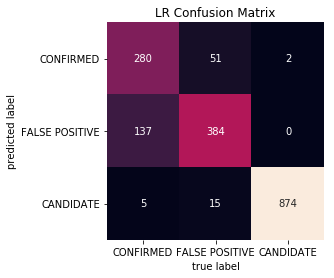

In [15]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
mat = confusion_matrix(y_test, prediction_grid)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=y.unique(),
            yticklabels=y.unique())
plt.xlabel('true label')
plt.ylabel('predicted label')
plt.title('LR Confusion Matrix')
plt.savefig('Output/LR_ConfusionMatrix.png')

In [16]:
# Train a new classifier using the best parameters found by the grid search
best_model = LogisticRegression(C = grid.best_estimator_.C,
                max_iter= grid.best_estimator_.max_iter)
best_LR_model = best_model.fit(X_train_new, y_train)
best_model_score = best_LR_model.score(X_test_new,y_test)
print(f'Best Model Score : {best_model_score}')

Best Model Score : 0.8615560640732265


/Users/morganivey/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/morganivey/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


In [ ]:
# original_model_test_score, original_classification_report
# test_score, 
# feature_selection_classification_report = classification_report(y_test,prediction_rfe,
#                             target_names=['CANDIDATE','CONFIRMED','FALSE POSITIVE'])
# best_model_score, best_model_classification_report


Percentage Increases:
Scaled model to Grid model : 1.2777%
Scaled model to Feature Selection model : 0.0672%
Feature Selection model to Grid model : 1.2097%


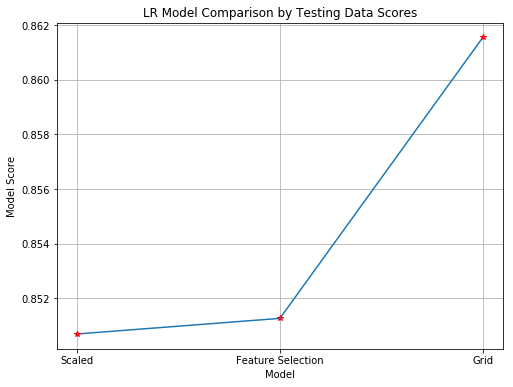

In [17]:
percInc_1 = ((best_model_score-test_score)/test_score)*100
percInc_2 = ((test_score-original_model_test_score)/original_model_test_score)*100
percInc_3 = ((best_model_score-original_model_test_score)/original_model_test_score)*100
print('Percentage Increases:')
print(f'Scaled model to Grid model : {round(percInc_3,4)}%')
print(f'Scaled model to Feature Selection model : {round(percInc_2,4)}%')
print(f'Feature Selection model to Grid model : {round(percInc_1,4)}%')
plt.figure(figsize=(8,6))
plt.plot([0,1,2],[original_model_test_score, test_score, best_model_score],marker='*',markeredgecolor='red')
plt.xticks([0,1,2],labels=['Scaled','Feature Selection','Grid'])
plt.xlabel('Model')
plt.ylabel('Model Score')
plt.title('LR Model Comparison by Testing Data Scores')
plt.grid()
plt.savefig('Output/LR_ModelComparison_TestingScores.png')

In [18]:
print('Classification Reports')
print('Scaled (MinMaxScaler):')
print(original_classification_report)
feature_selection_classification_report = classification_report(y_test,prediction_rfe,
                            target_names=['CANDIDATE','CONFIRMED','FALSE POSITIVE'])
print('---------------------------------------------------------')
print('Feature Selection (RFE)')
print(feature_selection_classification_report)
print('---------------------------------------------------------')
print('Grid')
print(best_model_classification_report)

file = open('Output/LR_classification_report.txt','w')
file.write('Classification Reports\n')
file.write('\nScaled (MinMaxScaler):\n')
file.write(original_classification_report)
file.write('\n---------------------------------------------------------\n')
file.write('Feature Selection (RFE)\n')
file.write(feature_selection_classification_report)
file.write('\n---------------------------------------------------------\n')
file.write('Grid\n')
file.write(best_model_classification_report)
file.close()

Classification Reports
Scaled (MinMaxScaler):
                precision    recall  f1-score   support

     CANDIDATE       0.76      0.61      0.68       422
     CONFIRMED       0.69      0.79      0.74       450
FALSE POSITIVE       0.98      1.00      0.99       876

     micro avg       0.85      0.85      0.85      1748
     macro avg       0.81      0.80      0.80      1748
  weighted avg       0.85      0.85      0.85      1748

---------------------------------------------------------
Feature Selection (RFE)
                precision    recall  f1-score   support

     CANDIDATE       0.76      0.61      0.68       422
     CONFIRMED       0.69      0.79      0.74       450
FALSE POSITIVE       0.98      1.00      0.99       876

     micro avg       0.85      0.85      0.85      1748
     macro avg       0.81      0.80      0.80      1748
  weighted avg       0.85      0.85      0.85      1748

---------------------------------------------------------
Grid
                pre

### Save the Model

In [19]:
import joblib
filename = 'morgan_ivey_LR.sav'
joblib.dump(best_LR_model, filename)

['morgan_ivey_LR.sav']